In [35]:
# Swing Trade Algorithm

In [36]:
!pip install alpaca-trade-api

In [37]:
#Import Required Libraries

import os
import requests
import pandas as pd
import hvplot.pandas
import numpy as np
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi


In [49]:
#Load .env environment variables

load_dotenv()

True

In [56]:
# Set Alpaca API Key 

alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')


In [57]:
# Creae the API object

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version='V2')

    

In [58]:
# Format current date as ISO format

start_date = pd.Timestamp('2010-01-01', tz='America/New_York').isoformat()
end_date= pd.Timestamp('2021-09-01', tz='America/New_York').isoformat()


# Set the tickers 

SPY = ['SPY']
QQQ = ['QQQ']
AAPL = ['AAPL']
NVDA = ['NVDA']
TWTR = ['TWTR']

    

In [59]:
# Set timeframe to one day ('1D') for the Alpaca API
timeframe = '15Min'

# Get current closing prices for SPY

SPY_df = alpaca.get_barset(
    SPY,
    timeframe,
    start = start_date,
    end = end_date,
    limit=1000
).df

# Display SPY df 

display(SPY_df.head())
display(SPY_df.tail())

SPY                                
                             open     high     low   close volume
time                                                             
2021-07-19 14:00:00-04:00  422.20  423.110  422.20  422.78  51481
2021-07-19 14:15:00-04:00  422.81  423.400  422.68  423.28  57938
2021-07-19 14:30:00-04:00  423.18  423.190  422.04  422.12  92180
2021-07-19 14:45:00-04:00  422.16  422.985  422.00  422.40  93611
2021-07-19 15:00:00-04:00  422.30  423.470  422.21  423.00  99272

SPY                                 
                             open     high     low   close  volume
time                                                              
2021-08-31 15:30:00-04:00  451.27  451.730  451.19  451.73  106889
2021-08-31 15:45:00-04:00  451.73  451.945  451.37  451.61  132775
2021-08-31 16:00:00-04:00  451.69  452.250  451.69  452.23    9968
2021-08-31 16:15:00-04:00  452.23  452.250  452.18  452.25    2500
2021-08-31 16:45:00-04:00  452.42  452.420  452.42  452.42     500

In [60]:
# Create df for SPY closing prices

SPY_close = pd.DataFrame()

SPY_close['close'] = SPY_df['SPY']['close']

# Drop the time component of the date

# SPY_close.index = SPY_close.index.time

# Review SPY DF

display(SPY_close.head())
display(SPY_close.tail())


,close
time,
2021-07-19 14:00:00-04:00,422.78
2021-07-19 14:15:00-04:00,423.28
2021-07-19 14:30:00-04:00,422.12
2021-07-19 14:45:00-04:00,422.40
2021-07-19 15:00:00-04:00,423.00


,close
time,
2021-08-31 15:30:00-04:00,451.73
2021-08-31 15:45:00-04:00,451.61
2021-08-31 16:00:00-04:00,452.23
2021-08-31 16:15:00-04:00,452.25
2021-08-31 16:45:00-04:00,452.42


In [61]:
SPY_signals = pd.DataFrame()


SPY_signals['close'] = SPY_close['close']
SPY_signals['returns'] = SPY_close['close'].pct_change()

SPY_signals = SPY_signals.dropna()

SPY_signals.head()

,close,returns
time,,
2021-07-19 14:15:00-04:00,423.28,0.001183
2021-07-19 14:30:00-04:00,422.12,-0.002741
2021-07-19 14:45:00-04:00,422.40,0.000663
2021-07-19 15:00:00-04:00,423.00,0.001420
2021-07-19 15:15:00-04:00,422.38,-0.001466


In [62]:
# Set the short window and long window
short_window = 3
long_window = 9

# Generate the fast and slow simple moving averages 
SPY_signals['SMA_Fast'] = SPY_signals['close'].rolling(window=short_window).mean()
SPY_signals['SMA_Slow'] = SPY_signals['close'].rolling(window=long_window).mean()

SPY_signals = SPY_signals.dropna()

# Review the DataFrame
display(SPY_signals.head())
display(SPY_signals.tail())

SPY_signals["signal"] = 0.0

,close,returns,SMA_Fast,SMA_Slow
time,,,,
2021-07-19 16:15:00-04:00,425.14,0.000282,424.920000,423.424444
2021-07-19 16:30:00-04:00,425.29,0.000353,425.150000,423.647778
2021-07-20 08:00:00-04:00,426.80,0.003551,425.743333,424.167778
2021-07-20 08:15:00-04:00,426.68,-0.000281,426.256667,424.643333
2021-07-20 08:30:00-04:00,426.38,-0.000703,426.620000,425.018889


,close,returns,SMA_Fast,SMA_Slow
time,,,,
2021-08-31 15:30:00-04:00,451.73,0.000997,451.481667,451.628889
2021-08-31 15:45:00-04:00,451.61,-0.000266,451.540000,451.619444
2021-08-31 16:00:00-04:00,452.23,0.001373,451.856667,451.660556
2021-08-31 16:15:00-04:00,452.25,0.000044,452.030000,451.725556
2021-08-31 16:45:00-04:00,452.42,0.000376,452.300000,451.816667


In [63]:
# Generate the trading signal 0 or 1,
# where 1 is the short-window (SMA50) greater than the long-window (SMA100)
# and 0 is when the condition is not met
SPY_signals["signal"][short_window:] = np.where(
    SPY_signals["SMA_Slow"][short_window:] > SPY_signals["SMA_Fast"][short_window:], 1.0, 0.0
)

# Review the DataFrame
SPY_signals.tail(10)

,close,returns,SMA_Fast,SMA_Slow,signal
time,,,,,
2021-08-31 14:15:00-04:00,451.600,-0.000144,451.708333,451.947778,1.0
2021-08-31 14:30:00-04:00,451.555,-0.000100,451.606667,451.847222,1.0
2021-08-31 14:45:00-04:00,451.840,0.000631,451.665000,451.787222,1.0
2021-08-31 15:00:00-04:00,451.435,-0.000896,451.610000,451.694444,1.0
2021-08-31 15:15:00-04:00,451.280,-0.000343,451.518333,451.612222,1.0
2021-08-31 15:30:00-04:00,451.730,0.000997,451.481667,451.628889,1.0
2021-08-31 15:45:00-04:00,451.610,-0.000266,451.540000,451.619444,1.0
2021-08-31 16:00:00-04:00,452.230,0.001373,451.856667,451.660556,0.0
2021-08-31 16:15:00-04:00,452.250,0.000044,452.030000,451.725556,0.0


In [64]:
# Initialize the new Signal column
# SPY_signals['signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
#SPY_signals.loc[(SPY_signals['returns'] >= 0), 'signal'] = 1

# When Actual Returns are less than 0, generate signal to hold 
# SPY_signals.loc[(SPY_signals['returns'] < 0), 'signal'] = 1

# Review the DataFrame
#display(SPY_signals.head())
# display(SPY_signals.tail())

In [65]:
# Initiate the value count

SPY_signals['signal'].value_counts()

0.0    582
1.0    409
Name: signal, dtype: int64

In [66]:
# Calculate the strategy returns and add them to the signals_df DataFrame
SPY_signals['strategy returns'] = SPY_signals['returns'] * SPY_signals['signal'].shift()

# Review the DataFrame
display(SPY_signals.head())
display(SPY_signals.tail())

,close,returns,SMA_Fast,SMA_Slow,signal,strategy returns
time,,,,,,
2021-07-19 16:15:00-04:00,425.14,0.000282,424.920000,423.424444,0.0,NaN
2021-07-19 16:30:00-04:00,425.29,0.000353,425.150000,423.647778,0.0,0.0
2021-07-20 08:00:00-04:00,426.80,0.003551,425.743333,424.167778,0.0,0.0
2021-07-20 08:15:00-04:00,426.68,-0.000281,426.256667,424.643333,0.0,-0.0
2021-07-20 08:30:00-04:00,426.38,-0.000703,426.620000,425.018889,0.0,-0.0


,close,returns,SMA_Fast,SMA_Slow,signal,strategy returns
time,,,,,,
2021-08-31 15:30:00-04:00,451.73,0.000997,451.481667,451.628889,1.0,0.000997
2021-08-31 15:45:00-04:00,451.61,-0.000266,451.540000,451.619444,1.0,-0.000266
2021-08-31 16:00:00-04:00,452.23,0.001373,451.856667,451.660556,0.0,0.001373
2021-08-31 16:15:00-04:00,452.25,0.000044,452.030000,451.725556,0.0,0.000000
2021-08-31 16:45:00-04:00,452.42,0.000376,452.300000,451.816667,0.0,0.000000


In [67]:
(1 + SPY_signals[['strategy returns','returns']]).cumprod().hvplot()

:NdOverlay   [Variable]
   :Curve   [time]   (value)

---

### Generating the Features and Target Sets

#### Create the features set

In [68]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = SPY_signals[['SMA_Fast', 'SMA_Slow']].copy()

# Display sample data
display(X.head())
display(X.tail())

,SMA_Fast,SMA_Slow
time,,
2021-07-19 16:15:00-04:00,424.920000,423.424444
2021-07-19 16:30:00-04:00,425.150000,423.647778
2021-07-20 08:00:00-04:00,425.743333,424.167778
2021-07-20 08:15:00-04:00,426.256667,424.643333
2021-07-20 08:30:00-04:00,426.620000,425.018889


,SMA_Fast,SMA_Slow
time,,
2021-08-31 15:30:00-04:00,451.481667,451.628889
2021-08-31 15:45:00-04:00,451.540000,451.619444
2021-08-31 16:00:00-04:00,451.856667,451.660556
2021-08-31 16:15:00-04:00,452.030000,451.725556
2021-08-31 16:45:00-04:00,452.300000,451.816667


#### Create the target set

In [69]:
# Create a new column in the SPY_signals called signal setting its value to zero.
SPY_signals['signal'] = 0.0

In [70]:
# Create the signal to buy
SPY_signals.loc[(SPY_signals['returns'] >= 0), 'signal'] = 1

In [71]:
# Create the signal to sell
SPY_signals.loc[(SPY_signals['returns'] < 0), 'signal'] = -1

In [72]:
# Copy the new signal column to a new Series called y.
y = SPY_signals['signal'].copy()

display(y.head())
display(y.tail())

time
2021-07-19 16:15:00-04:00    1.0
2021-07-19 16:30:00-04:00    1.0
2021-07-20 08:00:00-04:00    1.0
2021-07-20 08:15:00-04:00   -1.0
2021-07-20 08:30:00-04:00   -1.0
Name: signal, dtype: float64

time
2021-08-31 15:30:00-04:00    1.0
2021-08-31 15:45:00-04:00   -1.0
2021-08-31 16:00:00-04:00    1.0
2021-08-31 16:15:00-04:00    1.0
2021-08-31 16:45:00-04:00    1.0
Name: signal, dtype: float64

---

### Split the Data Into Training and Testing Datasets

#### Creating the Training Datasets

In [73]:
# Imports 
from pandas.tseries.offsets import DateOffset

In [74]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2021-07-19 16:15:00-04:00


In [75]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=1)

# Display the training end date
print(training_end)

2021-08-19 16:15:00-04:00


In [76]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,SMA_Fast,SMA_Slow
time,,
2021-07-19 16:15:00-04:00,424.920000,423.424444
2021-07-19 16:30:00-04:00,425.150000,423.647778
2021-07-20 08:00:00-04:00,425.743333,424.167778
2021-07-20 08:15:00-04:00,426.256667,424.643333
2021-07-20 08:30:00-04:00,426.620000,425.018889


In [77]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,SMA_Fast,SMA_Slow
time,,
2021-08-19 16:15:00-04:00,439.996667,439.710000
2021-08-19 16:30:00-04:00,440.003333,439.908889
2021-08-19 16:45:00-04:00,439.970000,440.056111
2021-08-20 08:30:00-04:00,439.626667,439.975000
2021-08-20 09:00:00-04:00,439.726667,440.000556


#### Standardizing the Data

In [78]:
# Imports
from sklearn.preprocessing import StandardScaler

In [79]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [80]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [81]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [82]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       332
         1.0       0.55      1.00      0.71       405

    accuracy                           0.55       737
   macro avg       0.27      0.50      0.35       737
weighted avg       0.30      0.55      0.39       737



C:\Users\zach_\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zach_\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zach_\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---

### Backtesting a Machine Learning Trading Algorithm

In [83]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [84]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       106
         1.0       0.58      1.00      0.74       149

    accuracy                           0.58       255
   macro avg       0.29      0.50      0.37       255
weighted avg       0.34      0.58      0.43       255



C:\Users\zach_\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zach_\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zach_\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = SPY_signals["returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
time,,,
2021-08-19 16:15:00-04:00,1.0,-0.000341,-0.000341
2021-08-19 16:30:00-04:00,1.0,0.000091,0.000091
2021-08-19 16:45:00-04:00,1.0,0.000023,0.000023
2021-08-20 08:30:00-04:00,1.0,-0.002455,-0.002455
2021-08-20 09:00:00-04:00,1.0,0.003121,0.003121


<AxesSubplot:xlabel='time'>

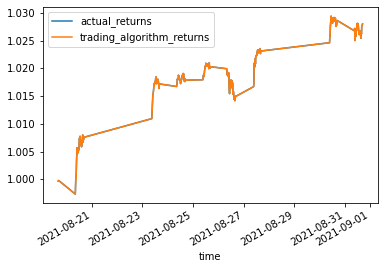

In [86]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---

# Add a New Machine Learning Model

## Step 2: Import the `LogisticRegression` model from scikit-learn.


In [87]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [88]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

## Step 3: Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

In [89]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

## Step 4: Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

In [90]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Diplay the predictions
lr_training_signal_predictions

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1

In [91]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.60      0.08      0.14       332
         1.0       0.56      0.96      0.71       405

    accuracy                           0.56       737
   macro avg       0.58      0.52      0.42       737
weighted avg       0.58      0.56      0.45       737



## Step 5: Backtest the `LogisticRegression` model using the testing data to evaluate its performance.


In [92]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [93]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.42      0.05      0.08       106
         1.0       0.58      0.95      0.72       149

    accuracy                           0.58       255
   macro avg       0.50      0.50      0.40       255
weighted avg       0.51      0.58      0.46       255



## Step 6: Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [94]:
# Print the classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.42      0.05      0.08       106
         1.0       0.58      0.95      0.72       149

    accuracy                           0.58       255
   macro avg       0.50      0.50      0.40       255
weighted avg       0.51      0.58      0.46       255



In [95]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       106
         1.0       0.58      1.00      0.74       149

    accuracy                           0.58       255
   macro avg       0.29      0.50      0.37       255
weighted avg       0.34      0.58      0.43       255

